In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from matplotlib import pyplot as plt

In [25]:
# ✅ Load the dataset (directly if CSV already exists)
df = pd.read_csv("/content/battery_data.csv")
df.head()

,Voltage,Current,Temp,Avg_Volt,Avg_Current,SOC,Voltage_dup
0,3.3350,11.624,1.179,3.33,11.654,20.643764,3.3350
1,3.3286,11.702,1.213,3.33,11.654,20.630979,3.3286
2,3.3365,11.615,1.229,3.33,11.654,20.631303,3.3365
3,3.3452,11.580,1.222,3.33,11.654,20.651254,3.3452
4,3.3277,11.572,1.230,3.33,11.654,20.628106,3.3277


In [26]:
# ✅ Drop unnecessary columns safely
df = df.drop(columns=['Voltage_dup', 'Avg_Volt', 'Avg_Current'], errors='ignore')
df.head()

,Voltage,Current,Temp,SOC
0,3.3350,11.624,1.179,20.643764
1,3.3286,11.702,1.213,20.630979
2,3.3365,11.615,1.229,20.631303
3,3.3452,11.580,1.222,20.651254
4,3.3277,11.572,1.230,20.628106


In [27]:
# Summary statistics
print(df.describe())

          Voltage     Current        Temp         SOC
count  700.000000  700.000000  700.000000  700.000000
mean     3.329919   11.653780    2.100891   20.640249
std      0.009856    0.049456    0.519742    0.009643
min      3.297600   11.505000    1.179000   20.613643
25%      3.323075   11.620000    1.644750   20.633505
50%      3.330000   11.654000    2.105000   20.640203
75%      3.336300   11.685000    2.548750   20.646668
max      3.368500   11.782000    3.016000   20.671099


In [28]:
# Correlations
correlation = df.corr(numeric_only=True)
print(correlation)

          Voltage   Current      Temp       SOC
Voltage  1.000000 -0.011397 -0.004168  0.093782
Current -0.011397  1.000000 -0.028745 -0.028571
Temp    -0.004168 -0.028745  1.000000  0.009522
SOC      0.093782 -0.028571  0.009522  1.000000


In [29]:
# Prepare features and target
features = df[['Voltage', 'Current', 'Temp']].values
target = df['SOC'].values

In [30]:
# ✅ Normalize features and target
mean_f = np.mean(features, axis=0)
std_f = np.std(features, axis=0)
features_norm = (features - mean_f) / std_f

mean_t = np.mean(target)
std_t = np.std(target)
target_norm = (target - mean_t) / std_t

In [31]:
# ✅ Manual train/test split
n = len(target)
indices = np.arange(n)
np.random.seed(42)  # reproducibility
np.random.shuffle(indices)
train_idx = indices[:int(0.8 * n)]
test_idx = indices[int(0.8 * n):]

X_train = features_norm[train_idx]
y_train = target_norm[train_idx]
X_test = features_norm[test_idx]
y_test = target_norm[test_idx]

In [32]:
# ✅ Convert to tensors
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float().unsqueeze(1)
X_test_t = torch.from_numpy(X_test).float()
y_test_t = torch.from_numpy(y_test).float().unsqueeze(1)

In [33]:
# ✅ Define the model
class SOCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = SOCModel()
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [34]:
# ✅ Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_t)
    loss = criterion(out, y_train_t)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}')

Epoch 50, Loss: 0.9495
Epoch 100, Loss: 0.9202
Epoch 150, Loss: 0.8777
Epoch 200, Loss: 0.8258


In [35]:
# ✅ Evaluate on test set
model.eval()
with torch.no_grad():
    pred_norm = model(X_test_t)
    test_loss_norm = criterion(pred_norm, y_test_t)
    print(f'Test MSE (normalized): {test_loss_norm.item():.4f}')

Test MSE (normalized): 1.1542


In [36]:
# ✅ Denormalize predictions
pred = pred_norm.detach().cpu().numpy() * std_t + mean_t
y_test_orig = y_test * std_t + mean_t

In [37]:
# ✅ Metrics
mse = np.mean((pred.flatten() - y_test_orig)**2)
print(f'Test MSE (original scale): {mse:.8f}')

ss_res = np.sum((y_test_orig - pred.flatten())**2)
ss_tot = np.sum((y_test_orig - np.mean(y_test_orig))**2)
r2 = 1 - (ss_res / ss_tot)
print(f'R2 Score: {r2:.4f}')

Test MSE (original scale): 0.00010717
R2 Score: -0.1196


In [38]:
# ✅ Comparison table
test_voltages = df.iloc[test_idx]['Voltage'].values
comparison_df = pd.DataFrame({
    'Voltage': test_voltages,
    'Actual SOC': y_test_orig,
    'Predicted SOC': pred.flatten(),
    'Difference': y_test_orig - pred.flatten()
})
print("\nComparison Table (First 20 samples):")
print(comparison_df.head(20))



Comparison Table (First 20 samples):
    Voltage  Actual SOC  Predicted SOC  Difference
0    3.3249   20.654314      20.644899    0.009414
1    3.3251   20.629081      20.641201   -0.012120
2    3.3250   20.655334      20.640970    0.014365
3    3.3350   20.644920      20.638623    0.006297
4    3.3366   20.641989      20.640187    0.001802
5    3.3224   20.644098      20.644366   -0.000269
6    3.3178   20.634264      20.639598   -0.005334
7    3.3384   20.658093      20.641215    0.016878
8    3.3211   20.643477      20.638448    0.005028
9    3.3202   20.626878      20.643394   -0.016516
10   3.3214   20.646125      20.636668    0.009457
11   3.3320   20.628694      20.637466   -0.008773
12   3.3154   20.633380      20.642479   -0.009098
13   3.3267   20.630517      20.638262   -0.007746
14   3.3221   20.646988      20.637622    0.009366
15   3.3383   20.629914      20.640565   -0.010650
16   3.3496   20.629861      20.648042   -0.018181
17   3.3325   20.650306      20.639728    0.

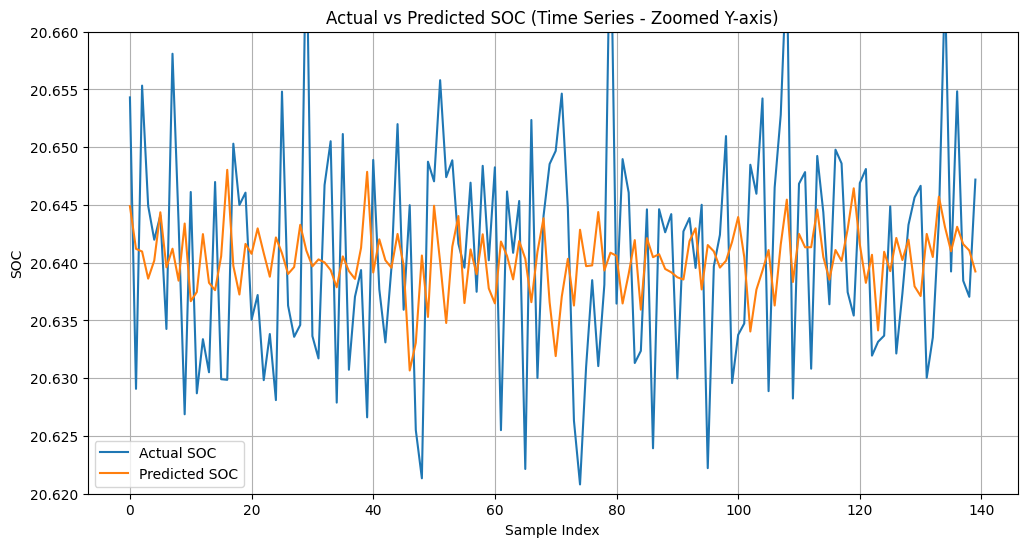

In [43]:
# ✅ Plot Actual vs Predicted SOC
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig, label='Actual SOC')
plt.plot(pred.flatten(), label='Predicted SOC')
plt.title('Actual vs Predicted SOC')
plt.xlabel('Sample Index')
plt.ylabel('SOC')
plt.legend()
plt.show()


Mean Absolute Error: 0.00863031
Mean Percentage Error: 0.0418%
Median Percentage Error: 0.0394%


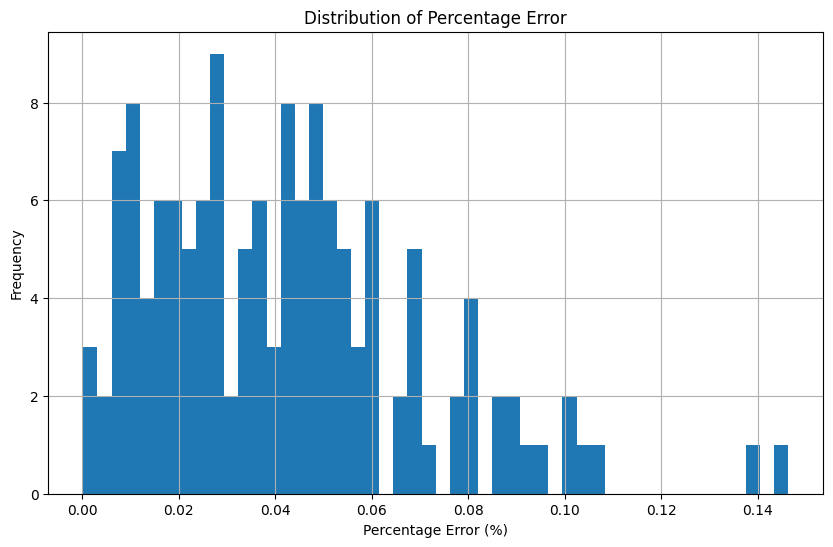

In [52]:
# Calculate and display error percentage
absolute_error = np.abs(y_test_orig - pred.flatten())
# Avoid division by zero if actual SOC is zero, which is not the case here based on data description
percentage_error = (absolute_error / y_test_orig) * 100

print(f"\nMean Absolute Error: {np.mean(absolute_error):.8f}")
print(f"Mean Percentage Error: {np.mean(percentage_error):.4f}%")
print(f"Median Percentage Error: {np.median(percentage_error):.4f}%")

# Optional: Plot distribution of percentage error
plt.figure(figsize=(10, 6))
plt.hist(percentage_error, bins=50)
plt.title('Distribution of Percentage Error')
plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

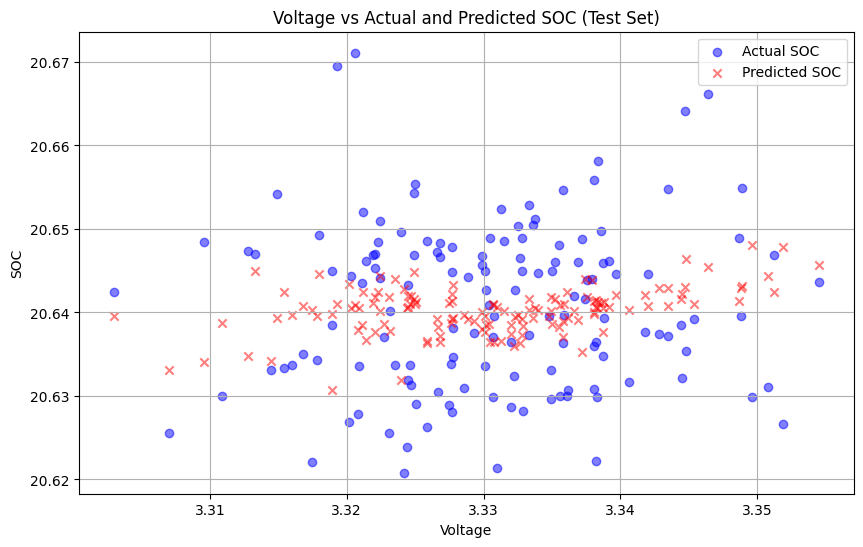

In [42]:
# ✅ Plot Voltage vs Actual and Predicted SOC
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.scatter(test_voltages, y_test_orig, color='blue', alpha=0.5, label='Actual SOC')
ax1.set_xlabel('Voltage')
ax1.set_ylabel('Actual SOC', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.scatter(test_voltages, pred.flatten(), color='red', alpha=0.5, label='Predicted SOC')
ax2.set_ylabel('Predicted SOC', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('Comparison of Voltage vs Actual/Predicted SOC (Test Set)')
fig.tight_layout()
plt.show()

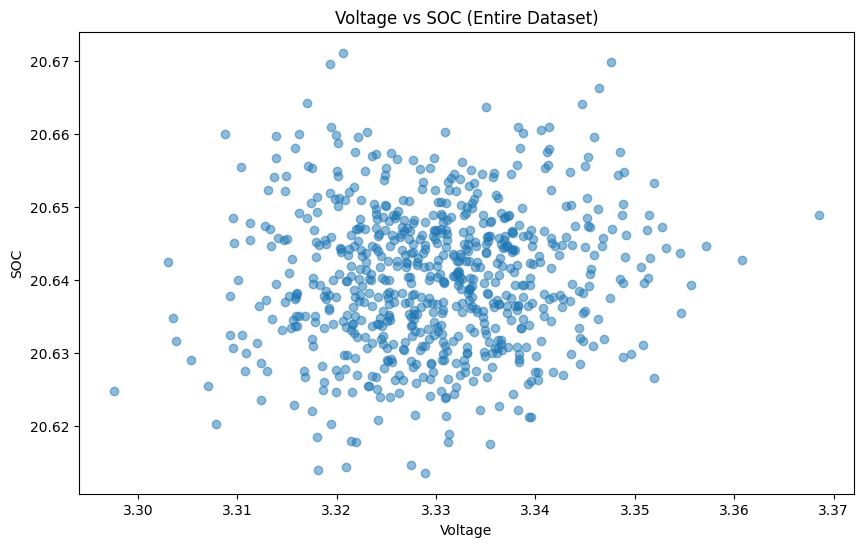

In [41]:
# ✅ Original Voltage vs SOC scatter (whole dataset)
plt.figure(figsize=(10, 6))
plt.scatter(df['Voltage'], df['SOC'], alpha=0.5)
plt.title('Voltage vs SOC (Entire Dataset)')
plt.xlabel('Voltage')
plt.ylabel('SOC')
plt.show()
